## Computer Vision in Agriculture

<table style="margin-left:0; text-align:left;">
<tr><td><b>Author(s):</b></td><td>Mahbub Alam</td></tr>
</table>


## Introduction

Machine learning pipeline for automated produce classification using k-Nearest Neighbors.
It trains a classifier on physical features (mass, width, height) extracted from visual inspection systems.
Typical in agricultural sorting facilities, where produce needs to be rapidly classified for quality control, pricing, or packaging.


#### Objectives


- Load and explore fruit feature data from visual inspection systems
- Train and evaluate a kNN classifier for multi-class fruit classification
- Analyze model performance and optimize hyperparameters
- Visualize decision boundaries and performance metrics
- Assess model sensitivity to training data size


#### Dataset


Features: mass (g), width (cm), height (cm), color_score

Target: fruit_label (1=apple, 2=mandarin, 3=orange, 4=lemon)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier # importing classifier constructor
import warnings
warnings.filterwarnings("ignore", message="Creating legend with loc=")

## Load and Explore Data

 We begin by loading the fruit dataset and examining its structure. This step helps us understand what features are available for classification and ensures the data is in the expected format.

In [2]:
fruits = pd.read_table('fruit_data_with_colors.txt')

print(fruits.head())

print(f"\nFeature names:")
print(fruits.columns) # Output: ['fruit_label', 'fruit_name', 'fruit_subtype', 'mass', 'width', 'height', 'color_score']

print(f"\nClass distribution:")
print(fruits['fruit_name'].value_counts())

   fruit_label fruit_name fruit_subtype  mass  width  height  color_score
0            1      apple  granny_smith   192    8.4     7.3         0.55
1            1      apple  granny_smith   180    8.0     6.8         0.59
2            1      apple  granny_smith   176    7.4     7.2         0.60
3            2   mandarin      mandarin    86    6.2     4.7         0.80
4            2   mandarin      mandarin    84    6.0     4.6         0.79

Feature names:
Index(['fruit_label', 'fruit_name', 'fruit_subtype', 'mass', 'width', 'height',
       'color_score'],
      dtype='object')

Class distribution:
fruit_name
apple       19
orange      19
lemon       16
mandarin     5
Name: count, dtype: int64


## Data Quality Check

 Before training any model, we check for missing values and examine the distribution of fruit classes. This ensures our data is clean and helps identify any class imbalance that might affect model performance.

In [3]:
missing_data = fruits.isna().any()  # returns bool on columns
cols_with_nan = fruits.columns[missing_data].to_list()
print(f"")

if cols_with_nan:
    print(f"Columns with missing data: {cols_with_nan}")
else:
    print("No missing data found - dataset is clean")

print(f"\nClass distribution:")
print(fruits['fruit_name'].value_counts())


No missing data found - dataset is clean

Class distribution:
fruit_name
apple       19
orange      19
lemon       16
mandarin     5
Name: count, dtype: int64


## Create Fruit Label Dictionary

 We create a dictionary to map between numeric labels and fruit names. This allows us to easily convert the model's numeric predictions back into human-readable fruit names.

In [4]:
lookup_fruit_name = dict(zip(fruits.fruit_label.unique(), fruits.fruit_name.unique()))
# print(lookup_fruit_name) # Output: {1: 'apple', 2: 'mandarin', 3: 'orange', 4: 'lemon'}

## Train-Test Split

 We split the data into training (75%) and testing (25%) sets. The training set is used to teach the model, while the test set evaluates how well it performs on unseen data, a crucial measure of real-world performance.

In [5]:
X = fruits[['mass', 'width', 'height']]
y = fruits['fruit_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

## Train KNN Classifier

 Now we train our k-Nearest Neighbors classifier with k=5. The kNN algorithm classifies each fruit by looking at the 5 nearest training examples and taking a majority vote. We then evaluate its accuracy on the test set and demonstrate predictions on new samples.

In [6]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5)

knn.fit(X_train, y_train)

print(f"Accuracy score: {knn.score(X_test, y_test)}")


example_fruits = pd.DataFrame([[20, 4.3, 5.1], [180, 7.8, 8.3]], columns = X.columns)
fruit_predictions = knn.predict(example_fruits)
print([lookup_fruit_name[label] for label in fruit_predictions])

Accuracy score: 0.5333333333333333
['mandarin', 'apple']


## Visualize Decision Boundaries

 This visualization shows how the classifier divides the feature space into regions. Each region corresponds to a fruit class, and any point falling in that region will be classified accordingly. This helps us understand how the model makes decisions.

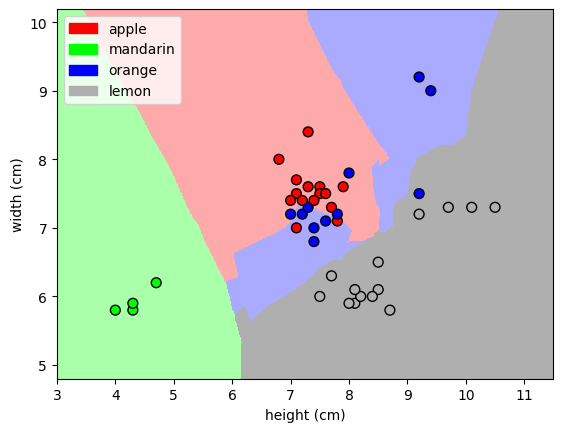

In [7]:
from utils import plot_fruit_knn

plot_fruit_knn(X_train, y_train, 5, 'uniform')

## Hyperparameter tuning: Optimal k

 The choice of k (number of neighbors) significantly impacts performance. We test different k values to find the optimal balance: too small causes overfitting to noise, too large may miss important patterns. This systematic search helps us maximize accuracy.

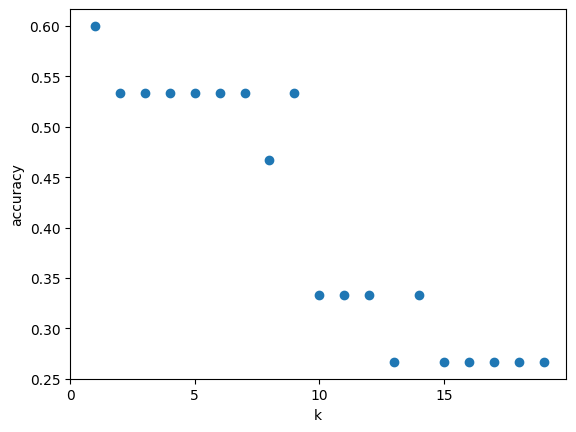

In [8]:
k_range = range(1, 20)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))

plt.figure()
plt.scatter(k_range, scores)
# Axis labels and title
plt.xlabel("k")
plt.ylabel("accuracy")
plt.xticks(range(0, 20, 5))
plt.savefig('knn_accuracy_vs_k.jpg')
plt.show()

## Model Robustness: Training Set Size Analysis

 In real-world applications, data collection can be expensive. This experiment evaluates how much training data we actually need. We run 1000 experiments for each training set size to get reliable performance estimates. This tells us the minimum data requirements for production deployment.

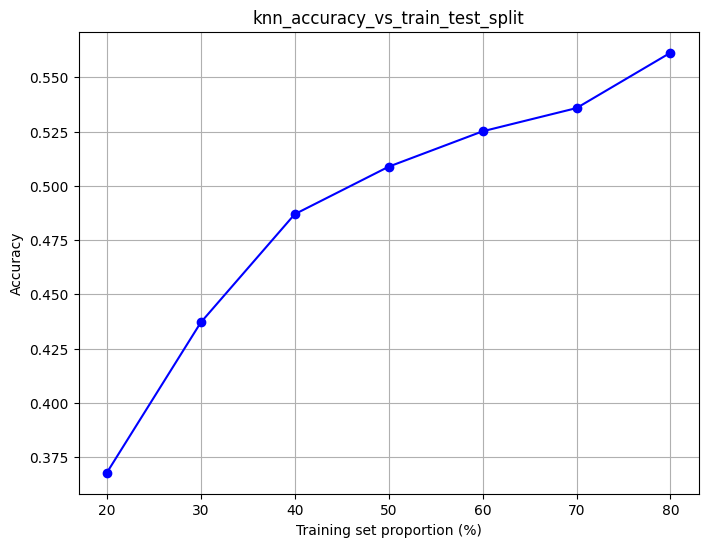

In [9]:
t = [0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]

knn = KNeighborsClassifier(n_neighbors = 5)

file_name = 'knn_accuracy_vs_train_test_split'

train_props = []
avg_scores = []

for s in t:
    scores = []
    for _ in range(1, 1000):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - s)
        knn.fit(X_train, y_train)
        scores.append(knn.score(X_test, y_test))

    train_props.append(s * 100)  # Convert to percentage
    avg_scores.append(np.mean(scores))

plt.figure(figsize=(8, 6))
plt.plot(train_props, avg_scores, 'bo-')  # Line with points
plt.xlabel('Training set proportion (%)')
plt.ylabel('Accuracy')
plt.title(file_name)
plt.grid(True)
plt.savefig(f'{file_name}.jpg')
plt.show()